## XenonPy-ISMD (Inversed Synthesizable Molecular Design) Totorial

This tutorial provides an introduction to ISMD, an inverse molecular design algorithm based on machine learning. By which we show a complete building process of doing your own inverse molecular design algorithm by XenonPy.

Overview - ISMD aims at finding reactant sets R, such that the properties Y of their synthetic product have a high probability of falling into a target region U, we want to sample from the posterior probability 𝑝(R|𝑌∈𝑈) that is proportional to 𝑝(𝑌∈𝑈|R)𝑝(R) by the Bayes' theorem. 𝑝(𝑌∈𝑈|R) is the likelihood function, 𝑝(R) is the prior that represents all possible candidates of R. ISMD is a numerical implementation for this Bayesian formulation based on sequential Monte Carlo sampling (SMC), all the building blocks to implement the SMC is supplied by XenonPy, the following of this tutorial will show how to customize each building block to solve the specific task in ISMD.

In [1]:
import warnings
warnings.filterwarnings('ignore')

### download data and model
download the data and model from the following link:\
https://drive.google.com/drive/folders/1-uHnS4EcV9dQdSEIlt1n8skCrsZJP-3r?usp=sharing \
which will be used in this tutorial. \
In your device, the a folder called ismd_assets should contain the following files:
- pool_sim_sparse.npz
- STEREO_id_reactant_product_xlogp_tpsa.csv
- STEREO_pool_df.csv
- STEREO_separated_augm_model_average_20.pt
- figure.png

In [2]:
import os
# set path to the downloaded folder
assets_path = "/home/qiz/data/ismd_assets"
from IPython.display import Image
Image(filename=os.path.join(assets_path, 'figure.png'), width=1000, height=600)

An illustruction of ISMD algorithm is shown above.\
ISMD is based on sequential Monte Carlo algorithm, which iterate the estimator(likelihood), modifier(prior), resample loop. Both of these blocks are available in XenonPy, however, we can customize them for a specific target.\
We will show how to customize and implement each blocks step by step.\
This tutorial will proceed as follow:
1. data introduction
  - ground truth
  - reactant pool
  - similarity matrix
  - initial data
2. estimator
  - featurizer
  - forward model
2. modifier
  - proposal
  - lookup pool
  - reactor
3. a complete ismd run

### 1. data introduction
#### ground truth
Ground truth is a pandas dataframe of real chemical reactions, each row is a chemical reaction record include reactant, product, some physical properties of the product('ECFP', 'MACCS') and the index of each reactant associated with the reactant pool.

In [3]:
import pandas as pd

ground_truth_path = os.path.join(assets_path,"STEREO_id_reactant_product_xlogp_tpsa.csv")
data = pd.read_csv(ground_truth_path)
data.head()

,reactant_index,reactant,product,XLogP,TPSA
0,12163.22445,CCS(=O)(=O)Cl.OCCBr,CCS(=O)(=O)OCCBr,0.8,51.8
1,863.20896,CC(C)CS(=O)(=O)Cl.OCCCl,CC(C)CS(=O)(=O)OCCCl,1.6,51.8
2,249087,O=[N+]([O-])c1cccc2cnc(Cl)cc12,Nc1cccc2cnc(Cl)cc12,2.4,38.9
3,153658.23440,Cc1cc2c([N+](=O)[O-])cccc2c[n+]1[O-].O=P(Cl)(C...,Cc1cc2c([N+](=O)[O-])cccc2c(Cl)n1,3.3,58.7
4,297070,CCCCC[C@H](O)C=CC1C=CC(=O)C1CC=CCCCC(=O)O,CCCCC[C@H](O)C=CC1CCC(=O)C1CC=CCCCC(=O)O,3.8,74.6


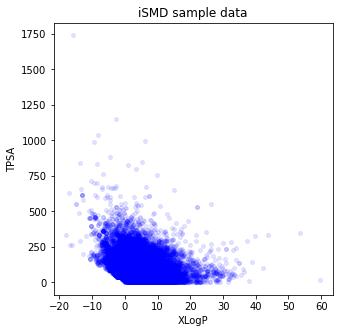

In [4]:
import matplotlib.pyplot as plt
# show the property distribution of ground truth
plt.figure(figsize=(5,5))
plt.scatter(data['XLogP'],data['TPSA'],s=15,c='b',alpha = 0.1)
plt.title('iSMD sample data')
plt.xlabel('XLogP')
plt.ylabel('TPSA')
plt.show()

#### reactant pool
The reactant pool is a pandas dataframe, each row is a reactant which is usable in the reaction.
an id column is optional for corresponding to the similarity matrix, if id is not given, use index instead.

In [5]:
reactant_pool_path = os.path.join(assets_path,"STEREO_pool_df.csv")
reactant_pool = pd.read_csv(reactant_pool_path)
print("Number of reactants is {}".format(len(reactant_pool)))
reactant_pool.head()

Number of reactants is 637645


,id,SMILES
0,0,O=C(Cl)Oc1ccc(Cc2ccc(C(F)(F)F)cc2)cc1
1,1,CCc1cc(C2CCN(C(=O)OC(C)(C)C)CC2)ccc1Nc1ncc(C(F...
2,2,CC(NC(=O)OCc1ccccc1)C(C)NC(=O)c1ccccc1O
3,3,OC[C@H]1NCC[C@@H]1O
4,4,C#CCCN1C(=O)c2ccccc2C1=O


#### similarity matrix
The similarity matrix is a pandas dataframe, the number of both row and column is the number of reactant in the reactant pool, each cell is the similarity between the reactant of the row's number and the column's number, so the values on the diagonal is 1.0.

In [6]:
%%time
from scipy import sparse

sim_matrix_path = os.path.join(assets_path,"pool_sim_sparse.npz")
reactant_pool_sim = sparse.load_npz(sim_matrix_path).tocsr()
sim_df = pd.DataFrame.sparse.from_spmatrix(reactant_pool_sim)
print("The size of similarity matrix is {} * {}".format(len(sim_df), len(list(sim_df))))

The size of similarity matrix is 637645 * 637645
CPU times: user 7.6 s, sys: 164 ms, total: 7.77 s
Wall time: 7.78 s


In [7]:
%%time
sim_df.head()

CPU times: user 2min 43s, sys: 367 ms, total: 2min 43s
Wall time: 2min 44s


,0,1,2,3,4,5,6,7,8,9,...,637635,637636,637637,637638,637639,637640,637641,637642,637643,637644
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### initial data
The sample data for SMC is a pandas dataframe which contains the following columns: reactant id, reactant SMILES, product SMILES.
In the SMC loop, the description of sample product will be cauculated firstly, then, the resample of reactant id will be performed. So, the initial data should at least contain the product and the reactant id.

In [8]:
sample_size = 100
data_sample = data.query("XLogP<3 & TPSA<50").sample(n=sample_size).reset_index(drop=True)
init_samples = pd.DataFrame({'reactant_idx': [],
                       'reactant_smiles': [],
                       'product_smiles': []})


init_samples['reactant_idx'] = [[int(a) for a in idx_str.split('.')] for idx_str in data_sample['reactant_index']]
init_samples['product_smiles'] = data_sample['product']
init_samples.head()

,reactant_idx,reactant_smiles,product_smiles
0,"[472474, 391471]",NaN,O=c1[nH]c(-c2ccc(Br)cc2)cn2nc(CBr)cc12
1,"[51440, 42254]",NaN,CN1CC(CCN2CCN(c3ccc(Br)cc3)CC2)OC1=O
2,"[12454, 343195]",NaN,Cc1ccc(F)cc1C(C)(C)CC(=O)N1CCOCC1
3,"[7552, 409251]",NaN,O=C1c2ccccc2C(=O)N1OCF
4,"[28964, 16665]",NaN,Fc1ccc(CCNC2CC2)cc1


### estimator
#### featurizer
featurizer calculate the fingerprint of the sample product. We currently support all fingerprints and descriptors in the RDKit (Mordred will be added soon). In this tutorial, we only use the ECFP + MACCS in RDKit. 

In [9]:
%%time

from xenonpy.descriptor import Fingerprints
product_descriptor = Fingerprints(featurizers=['ECFP', 'MACCS'], input_type='smiles', on_errors='nan', target_col='product_smiles')
samples_feature = product_descriptor.transform(init_samples)

CPU times: user 861 ms, sys: 406 ms, total: 1.27 s
Wall time: 2.94 s


In [10]:
samples_feature.head()

,maccs:0,maccs:1,maccs:2,maccs:3,maccs:4,maccs:5,maccs:6,maccs:7,maccs:8,maccs:9,...,ecfp6:2038,ecfp6:2039,ecfp6:2040,ecfp6:2041,ecfp6:2042,ecfp6:2043,ecfp6:2044,ecfp6:2045,ecfp6:2046,ecfp6:2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### forward model
Forward model compute the likelihood of the product's property falling into the target likelihood.\
In this tutorial, we train two regerssion models for the two property respectively.

In [11]:
%%time
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split

n_train = 100000
training_df = data.iloc[:n_train]
trainer_descriptor = Fingerprints(featurizers=['ECFP', 'MACCS'], input_type='smiles', on_errors='nan', target_col='product')
training_fp = trainer_descriptor.transform(training_df)

training_XLogP = training_df["XLogP"].tolist()
training_TPSA = training_df["TPSA"].tolist()
model_XLogP = BayesianRidge()
model_TPSA = BayesianRidge()


X_train_XLogP, X_test_XLogP, y_train_XLogP, y_test_XLogP = train_test_split(training_fp, training_XLogP, test_size=0.25, random_state=42)
X_train_TPSA, X_test_TPSA, y_train_TPSA, y_test_TPSA = train_test_split(training_fp, training_TPSA, test_size=0.25, random_state=42)

model_XLogP.fit(X_train_XLogP, y_train_XLogP)
model_TPSA.fit(X_train_TPSA, y_train_TPSA)

y_train_XLogP_pred = model_XLogP.predict(X_train_XLogP)
y_train_TPSA_pred = model_TPSA.predict(X_train_TPSA)
y_test_XLogP_pred = model_XLogP.predict(X_test_XLogP)
y_test_TPSA_pred = model_TPSA.predict(X_test_TPSA)

CPU times: user 4min 8s, sys: 5.83 s, total: 4min 13s
Wall time: 1min 50s


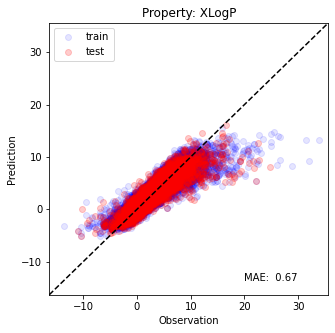

In [12]:
import numpy as np

y_all = training_XLogP
y_train_true = y_train_XLogP
y_train_pred = y_train_XLogP_pred
y_test_true = y_test_XLogP
y_test_pred = y_test_XLogP_pred

y_min = min(y_all)*0.95
y_max = max(y_all)*1.05
y_diff = y_max - y_min

plt.figure(figsize=(5,5))
plt.scatter(y_train_true, y_train_pred, c='b', alpha=0.1, label='train')
plt.scatter(y_test_true, y_test_pred, c='r', alpha=0.2, label='test')
plt.text(y_min+y_diff*0.7,y_min+y_diff*0.05,'MAE: {:5.2f}'.format(np.mean(np.abs(y_test_true - y_test_pred)),fontsize=12))
plt.xlim(y_min,y_max)
plt.ylim(y_min,y_max)
plt.legend(loc='upper left')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Property: XLogP')
plt.plot([y_min,y_max],[y_min,y_max],ls="--",c='k')

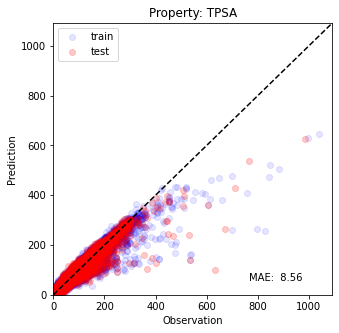

In [13]:
y_all = training_TPSA
y_train_true = y_train_TPSA
y_train_pred = y_train_TPSA_pred
y_test_true = y_test_TPSA
y_test_pred = y_test_TPSA_pred

y_min = min(y_all)*0.95
y_max = max(y_all)*1.05
y_diff = y_max - y_min

plt.figure(figsize=(5,5))
plt.scatter(y_train_true, y_train_pred, c='b', alpha=0.1, label='train')
plt.scatter(y_test_true, y_test_pred, c='r', alpha=0.2, label='test')
plt.text(y_min+y_diff*0.7,y_min+y_diff*0.05,'MAE: {:5.2f}'.format(np.mean(np.abs(y_test_true - y_test_pred)),fontsize=12))
plt.xlim(y_min,y_max)
plt.ylim(y_min,y_max)
plt.legend(loc='upper left')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Property: TPSA')
plt.plot([y_min,y_max],[y_min,y_max],ls="--",c='k')

Merge the featurizer and forward model into the estimator(likelihood) module, we get the first block of ISMD.\
In this tutorial, we use GaussianLogLikelihood as the the estimator.

In [14]:
from xenonpy.inverse.iqspr import GaussianLogLikelihood

## set property target
prop = ['XLogP', 'TPSA']
target_range = {'XLogP': (5, 10), 'TPSA': (50, 100)}
likelihood_calculator = GaussianLogLikelihood(descriptor=product_descriptor, targets=target_range, XLogP=model_XLogP, TPSA=model_TPSA)
samples_likelihood = likelihood_calculator(init_samples)
samples_likelihood.head()

,XLogP,TPSA
0,-4.814539,-1.386888
1,-4.971198,-1.961522
2,-4.283847,-3.617231
3,-11.311009,-2.119368
4,-5.008165,-7.717772


### 3. modifier
#### proposal
Proposal substitute a randomly selected reactant by a similar one.

In [15]:
%%time
from xenonpy.contrib.ismd import ReactantPool
from xenonpy.contrib.ismd import load_reactor

model_path = os.path.join(assets_path,'STEREO_separated_augm_model_average_20.pt')
mol_reactor = load_reactor(model_path=model_path, device_id=-1)
mol_pool = ReactantPool(pool_df=reactant_pool, sim_df=sim_df, reactor=mol_reactor)

CPU times: user 1.2 s, sys: 83.5 ms, total: 1.29 s
Wall time: 161 ms


In [16]:
old_list = [str(r) for r in init_samples["reactant_idx"][:5]]
new_list = [mol_pool.single_proposal(reactant) for reactant in init_samples["reactant_idx"]]
init_samples["reactant_idx"] = new_list
print("{:25} ---> {:25}".format("old idx","new idx"))
for o,n in zip(old_list[:5], new_list[:5]):
    print("{:25} ---> {:25}".format(str(o),str(n)))

old idx                   ---> new idx                  
[472474, 391471]          ---> [190823, 391471]         
[51440, 42254]            ---> [308994, 42254]          
[12454, 343195]           ---> [327177, 343195]         
[7552, 409251]            ---> [509903, 409251]         
[28964, 16665]            ---> [28964, 554908]          


#### lookup pool
By looking up the reactant pool, convert reactant id to SMILES.

In [17]:
init_samples["reactant_smiles"] = [mol_pool.single_index2reactant(id_str) for id_str in init_samples["reactant_idx"]]
print("{:25} ---> {:25}".format("reactant idx","reactant SMILES"))
for o,n in zip(init_samples["reactant_idx"][:5], init_samples["reactant_smiles"][:5]):
    print("{:25} ---> {:25}".format(str(o),str(n)))

reactant idx              ---> reactant SMILES          
[190823, 391471]          ---> COC(=O)C(C)(C)NC(=O)Nc1ccc(Cl)c(C(F)(F)F)c1.O=c1[nH]c(-c2ccc(Br)cc2)cn2nc(CO)cc12
[308994, 42254]           ---> C#Cc1ccc(N2CCNCC2)cc1.CN1CC(CCCl)OC1=O
[327177, 343195]          ---> C1COCCNN1.Cc1ccc(F)cc1C(C)(C)CC(=O)O
[509903, 409251]          ---> CC(C)Cc1ccc(C(CC(=O)O)C(=O)O)s1.O=C1c2ccccc2C(=O)N1O
[28964, 554908]           ---> NC1CC1.O=C(O)Cc1ccc(-c2ccc(F)cc2)cc1


#### reactor
The reactor can predict the product given the reactant set.

In [18]:
init_samples["product_smiles"] = mol_pool._reactor.react(init_samples["reactant_smiles"])
init_samples.head()

,reactant_idx,reactant_smiles,product_smiles
0,"[190823, 391471]",COC(=O)C(C)(C)NC(=O)Nc1ccc(Cl)c(C(F)(F)F)c1.O=...,CC(C)(NC(=O)Nc1ccc(Cl)c(C(F)(F)F)c1)C(=O)OCc1c...
1,"[308994, 42254]",C#Cc1ccc(N2CCNCC2)cc1.CN1CC(CCCl)OC1=O,C#Cc1ccc(N2CCN(CCC3CN(C)C(=O)O3)CC2)cc1
2,"[327177, 343195]",C1COCCNN1.Cc1ccc(F)cc1C(C)(C)CC(=O)O,Cc1ccc(F)cc1C(C)(C)CC(=O)N1CCOCCN1
3,"[509903, 409251]",CC(C)Cc1ccc(C(CC(=O)O)C(=O)O)s1.O=C1c2ccccc2C(...,CC(C)Cc1ccc(C(CC(=O)ON2C(=O)c3ccccc3C2=O)C(=O)...
4,"[28964, 554908]",NC1CC1.O=C(O)Cc1ccc(-c2ccc(F)cc2)cc1,O=C(Cc1ccc(-c2ccc(F)cc2)cc1)NC1CC1


### 4. a complete ismd run
In this tutorial, we use IQSPR4DF as the SMC framework, which is usable for pandas dataframe. Merge the estimator and the modifier into the IQSPR4DF module, then, a complete implementation is ready to run.

In [19]:
from xenonpy.inverse.iqspr import IQSPR4DF

ISMD = IQSPR4DF(estimator=likelihood_calculator, modifier=mol_pool, sample_col='product_smiles')

In [20]:
import numpy as np

beta = np.hstack([np.linspace(0.01,0.2,20),np.linspace(0.21,0.4,10),np.linspace(0.4,1,10),np.linspace(1,1,10)])
beta

array([0.01      , 0.02      , 0.03      , 0.04      , 0.05      ,
       0.06      , 0.07      , 0.08      , 0.09      , 0.1       ,
       0.11      , 0.12      , 0.13      , 0.14      , 0.15      ,
       0.16      , 0.17      , 0.18      , 0.19      , 0.2       ,
       0.21      , 0.23111111, 0.25222222, 0.27333333, 0.29444444,
       0.31555556, 0.33666667, 0.35777778, 0.37888889, 0.4       ,
       0.4       , 0.46666667, 0.53333333, 0.6       , 0.66666667,
       0.73333333, 0.8       , 0.86666667, 0.93333333, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [21]:
%%time

np.random.seed(201906) # fix the random seed
# main loop of iQSPR
iqspr_samples1, iqspr_loglike1, iqspr_prob1, iqspr_freq1 = [], [], [], []
for s, ll, p, freq in ISMD(init_samples, beta, yield_lpf=True):
    iqspr_samples1.append(s)
    iqspr_loglike1.append(ll)
    iqspr_prob1.append(p)
    iqspr_freq1.append(freq)
# record all outputs
iqspr_results_reorder = {
    "samples": iqspr_samples1,
    "loglike": iqspr_loglike1,
    "prob": iqspr_prob1,
    "freq": iqspr_freq1,
    "beta": beta
}


CPU times: user 1h 50min 49s, sys: 7min 54s, total: 1h 58min 43s
Wall time: 16min 2s


By looking at the likelihood of each steps, we can say that after few steps, most of the particles sampled have high likelihood.

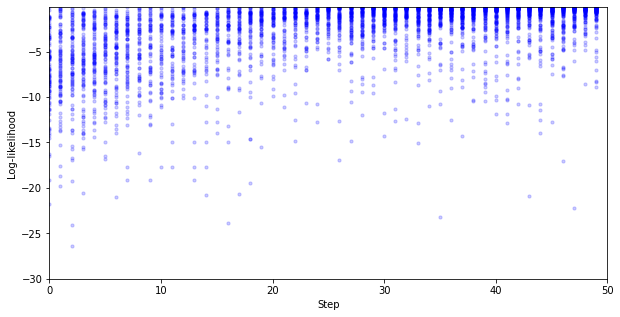

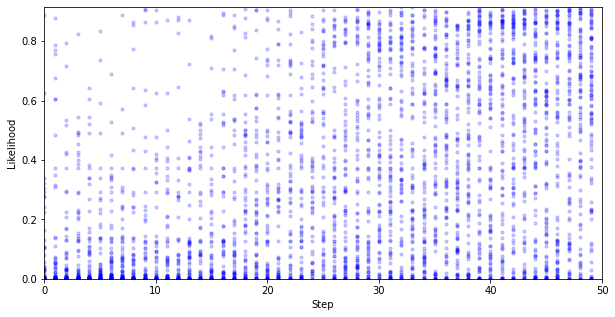

In [22]:
import matplotlib.pyplot as plt

iqspr_results_reorder = {
    "samples": iqspr_samples1,
    "loglike": iqspr_loglike1,
    "prob": iqspr_prob1,
    "freq": iqspr_freq1,
    "beta": beta
}
# set up the min and max boundary for the plots
tmp_list = [x.sum(axis = 1, skipna = True).values for x in iqspr_results_reorder["loglike"]]
flat_list = np.asarray([item for sublist in tmp_list for item in sublist])
y_max, y_min = max(flat_list), min(flat_list)

plt.figure(figsize=(10,5))
plt.xlim(0,len(iqspr_results_reorder["loglike"]))
plt.ylim(-30,y_max)
plt.xlabel('Step')
plt.ylabel('Log-likelihood')
for i, ll in enumerate(tmp_list):
    plt.scatter([i]*len(ll), ll ,s=10, c='b', alpha=0.2)
plt.show()
#plt.savefig('iqspr_loglike_reorder.png',dpi = 500)
#plt.close()

y_max, y_min = np.exp(y_max), np.exp(y_min)
plt.figure(figsize=(10,5))
plt.xlim(0,len(iqspr_results_reorder["loglike"]))
plt.ylim(y_min,y_max)
plt.xlabel('Step')
plt.ylabel('Likelihood')
for i, ll in enumerate(tmp_list):
    plt.scatter([i]*len(ll), np.exp(ll) ,s=10, c='b', alpha=0.2)